# Init and spot detection

In [ ]:
import numpy as np
import pbwrap.detection as detection
import bigfish.plot as plot

from pbwrap.utils import open_image

voxel_size = (200,97,97) #nm/px
bead_size = (200*25,103,103) #nm/px
threshold_penalty = 10

## Open images

In [ ]:
path = "/media/floricslimani/SSD 4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/Beads-Field_01.tif"
image = open_image(path)

print(image.shape)
color1=image[10:35,:,:,0]
color2=image[10:35,:,:,1]
color3=image[10:35,:,:,2]

assert color1.shape == color2.shape == color3.shape
shape = color1.shape
print("shape : ", shape)

## Spot detection

In [ ]:
color1_spots, color1_threshold = detection.detect_spots(
    images= color1,
    threshold_penalty=1,
    voxel_size=voxel_size,
    spot_radius= bead_size,
    return_threshold=True,
    ndim=3
)

print("Threshold for spots in color1 : ", color1_threshold)
print(len(color1_spots)," spots detected")

In [ ]:
color2_spots, color2_threshold = detection.detect_spots(
    images= color2,
    threshold_penalty=1,
    voxel_size=voxel_size,
    spot_radius= bead_size,
    return_threshold=True,
    ndim=3
)

print("Threshold for spots in color2 : ", color2_threshold)
print(len(color2_spots)," spots detected")

In [ ]:
color3_spots, color3_threshold = detection.detect_spots(
    images= color3,
    threshold_penalty=1,
    voxel_size=voxel_size,
    spot_radius= bead_size,
    return_threshold=True,
    ndim=3
)

print("Threshold for spots in color3 : ", color3_threshold)
print(len(color3_spots)," spots detected")

In [ ]:
reference_spots = color1_spots
other_spots = [color2_spots, color3_spots]
other_spots_name = ['color2', 'color3']

## Napari Viewer

In [ ]:
import napari

Viewer = napari.Viewer()

#Images
Viewer.add_image(color1, blending= 'additive', colormap='red', scale=voxel_size)
Viewer.add_image(color2, blending= 'additive', colormap='green', scale=voxel_size)
Viewer.add_image(color3, blending= 'additive', colormap='blue', scale=voxel_size)

#spots
Viewer.add_points(
    color1_spots,
    scale=voxel_size,
    face_color='red',
    symbol= 'ring',
    visible=False,
)

Viewer.add_points(
    color2_spots,
    scale=voxel_size,
    face_color='green',
    symbol= 'ring',
    visible=False,
)

Viewer.add_points(
    color3_spots,
    scale=voxel_size,
    face_color='blue',
    symbol= 'ring',
    visible=False,
)


napari.run()

# Building distance DataFrame

## Spots distance distribution

Let's take color 1 as reference and compute distance of other colors spots to spots detected in color1.

In [ ]:
import pandas as pd
from scipy.ndimage import distance_transform_edt

### Distance map
*Note that we also get the indices map to be able to match spots to their closest spots in reference channel.*

In [ ]:
reference_spots_array = np.ones(shape=shape)
Z,Y,X = zip(*reference_spots)
reference_spots_array[Z,Y,X] = 0
distance_map, indices_map = distance_transform_edt(reference_spots_array, sampling=voxel_size, return_indices=True)

### Building dataframe

In [474]:
distance_df = pd.DataFrame()

for spots, name in zip(other_spots, other_spots_name) :
    Z,Y,X = zip(*spots)
    distance_to_closest_spot = distance_map[Z,Y,X]
    Z_closest = indices_map[0][Z,Y,X]
    Y_closest = indices_map[1][Z,Y,X]
    X_closest = indices_map[2][Z,Y,X]

    distance_df = pd.concat([
        distance_df,
        pd.DataFrame({
            'channel' : [name] * len(Z),
            'Z' : Z,
            'Y' : Y,
            'X' : X,
            'distance_to_reference_spot' : distance_to_closest_spot,
            'matching_Z' : Z_closest,
            'matching_Y' : Y_closest,
            'matching_X' : X_closest,
        })
    ]).reset_index(drop=True)

print(distance_df)

     channel   Z     Y     X  distance_to_reference_spot  matching_Z  \
0     color2   4     0   465                 4009.397960          24   
1     color2   3     2  1921                 3816.060403          22   
2     color2   3    23  1944                 3427.561816          20   
3     color2   2    66  1733                 4214.536392          23   
4     color2   1    66  1881                 4015.260515          21   
...      ...  ..   ...   ...                         ...         ...   
1064  color3  24  1167  1381                  402.885840          23   
1065  color3  24  1412  1561                  584.027397          23   
1066  color3  24  1424   964                  533.511012          23   
1067  color3  24  1473  1075                  399.941246          24   
1068  color3  24  1508  1098                  533.511012          23   

      matching_Y  matching_X  
0              2         467  
1              4        1918  
2             25        1940  
3          

We add distance on indidividual axis : dz ,dy, dx

In [475]:
distance_df['dz'] = distance_df['Z'] - distance_df['matching_Z']
distance_df['dy'] = distance_df['Y'] - distance_df['matching_Y']
distance_df['dx'] = distance_df['X'] - distance_df['matching_X']

print(distance_df)

     channel   Z     Y     X  distance_to_reference_spot  matching_Z  \
0     color2   4     0   465                 4009.397960          24   
1     color2   3     2  1921                 3816.060403          22   
2     color2   3    23  1944                 3427.561816          20   
3     color2   2    66  1733                 4214.536392          23   
4     color2   1    66  1881                 4015.260515          21   
...      ...  ..   ...   ...                         ...         ...   
1064  color3  24  1167  1381                  402.885840          23   
1065  color3  24  1412  1561                  584.027397          23   
1066  color3  24  1424   964                  533.511012          23   
1067  color3  24  1473  1075                  399.941246          24   
1068  color3  24  1508  1098                  533.511012          23   

      matching_Y  matching_X  dz  dy  dx  
0              2         467 -20  -2  -2  
1              4        1918 -19  -2   3  
2     

# Plots

## Distance plotting in Cartesian coordinates

In [498]:
import matplotlib.pyplot as plt

### General distribution

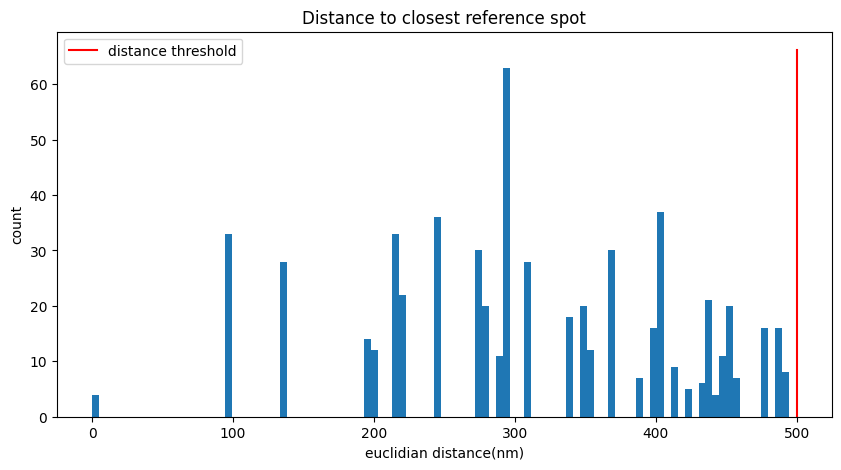

distance_threshold :  500


In [499]:
fig = plt.figure(figsize=(10,5))
distance_threshold = 500
plt.hist(distance_df['distance_to_reference_spot'], density=False, bins= 100)
xmin,xmax,ymin,ymax = plt.axis()
plt.plot([distance_threshold,distance_threshold],[ymin,ymax],'r', label='distance threshold')
plt.legend()
plt.xlabel('euclidian distance(nm)')
plt.ylabel('count')
plt.title('Distance to closest reference spot')
plt.show()
print('distance_threshold : ',distance_threshold)

In [500]:
distance_df = distance_df.loc[distance_df['distance_to_reference_spot'] <= distance_threshold]

### Di = f(i)

/tmp/ipykernel_56311/1209749294.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


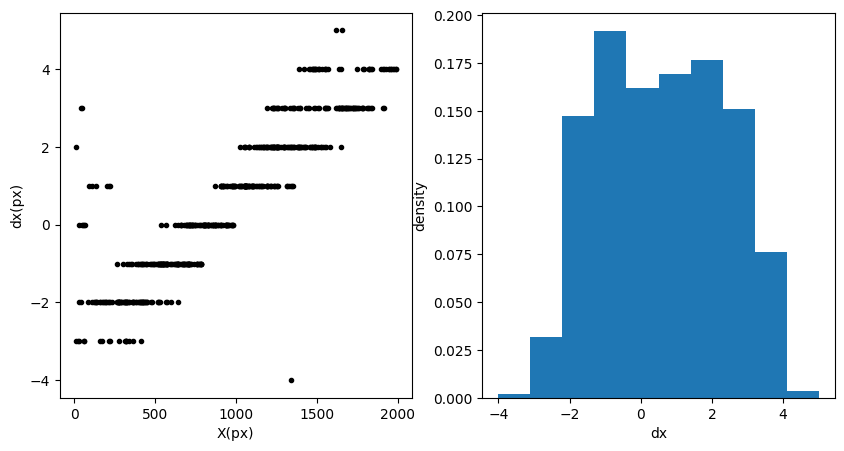

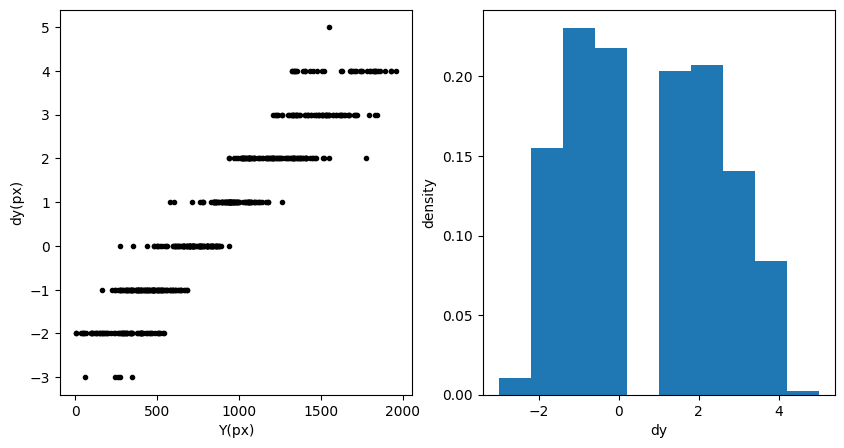

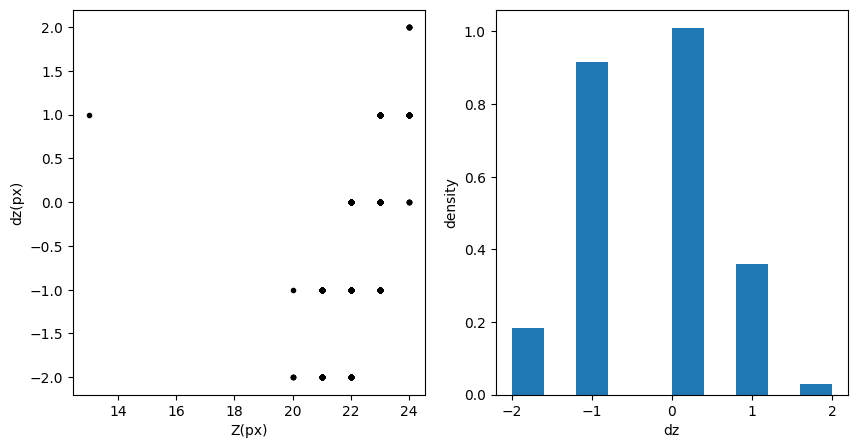

In [501]:
for i,di in zip(['X','Y','Z'], ['dx','dy','dz']) :
    fig = plt.figure(figsize=(10,5))
    left,right = fig.subplots(1,2)
    left.plot(
        distance_df[i],
        distance_df[di],
        '.k'
    )
    left.set_xlabel('{0}(px)'.format(i))
    left.set_ylabel('{0}(px)'.format(di))

    right.hist(distance_df[di], density=True, bins=10)
    right.set_xlabel(di)
    right.set_ylabel('density')

    fig.show()

### Finding optical center

We are looking for the x,y coordinates where dx = 0 and dy = 0

In [502]:
center_df = distance_df.loc[
    distance_df['distance_to_reference_spot'] == 0,
]
center_X, center_Y = distance_df['X'].median(), distance_df['Y'].median()
print(center_df['distance_to_reference_spot'])

175     0.0
462     0.0
976     0.0
1014    0.0
Name: distance_to_reference_spot, dtype: float64


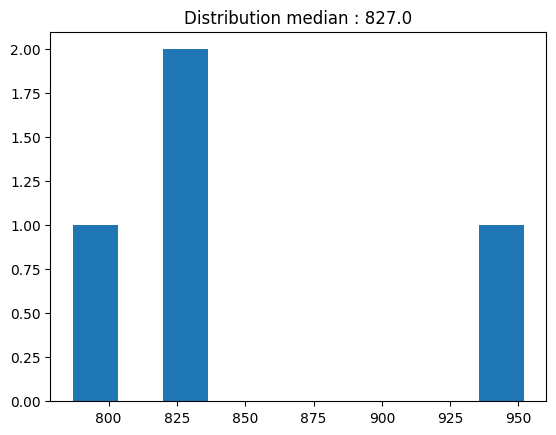

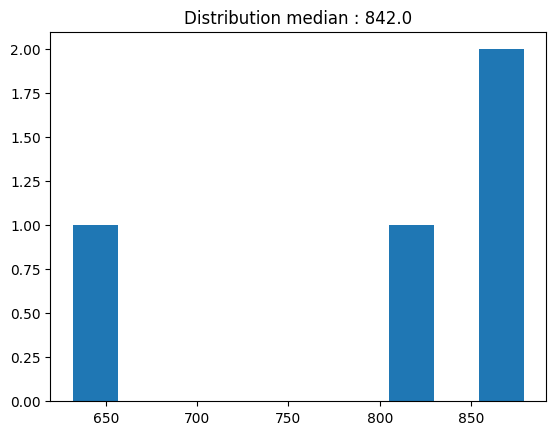

In [503]:
for i in ['X','Y'] :
    plt.figure()
    plt.hist(center_df[i])
    plt.title("Distribution median : " + str(center_df[i].median()))
    plt.show()



## Conversion to cylindrical coordinates

### Shifting coordinates center to above calculated optical center

In [504]:
distance_df['X'] -= center_X
distance_df['Y'] -= center_Y

### Computing cylindrical distance

In [505]:
distance_df.loc[:,['r']] = (distance_df['X'].apply(np.square) + distance_df['Y'].apply(np.square)).apply(np.sqrt)
distance_df.loc[:,['matching_r']] = (distance_df['matching_X'].apply(np.square) + distance_df['matching_Y'].apply(np.square)).apply(np.sqrt)
distance_df.loc[:,['angle']] = np.arctan2(distance_df['X'], distance_df['Y'])
distance_df.loc[:,['angle(deg)']] = distance_df['angle']*180/np.pi
distance_df.loc[:,['matching_angle']] = np.arctan2(distance_df['matching_X'], distance_df['matching_Y'])
distance_df.loc[:,['dr']] = distance_df['r'] - distance_df['matching_r']
distance_df.loc[:,['d_angle']] = distance_df['angle'] - distance_df['matching_angle']

print(distance_df.loc[:,['X','Y','r','angle']])


          X       Y            r     angle
52   -675.0  1101.0  1291.443379 -0.549981
74   -684.0  -764.0  1025.452095 -2.411387
77    -44.0  1068.0  1068.905983 -0.041175
79    397.0  -801.0   893.985458  2.681447
84   -925.0   -35.0   925.661925 -1.608616
...     ...     ...          ...       ...
1061  -24.0   185.0   186.550261 -0.129009
1062 -143.0   201.0   246.677928 -0.618364
1063  107.0   257.0   278.384626  0.394515
1064  434.0   310.0   533.344167  0.950547
1067  128.0   616.0   629.158168  0.204877

[597 rows x 4 columns]


## Relations between cylindrical parameters

### Free parameters

/tmp/ipykernel_56311/533642545.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


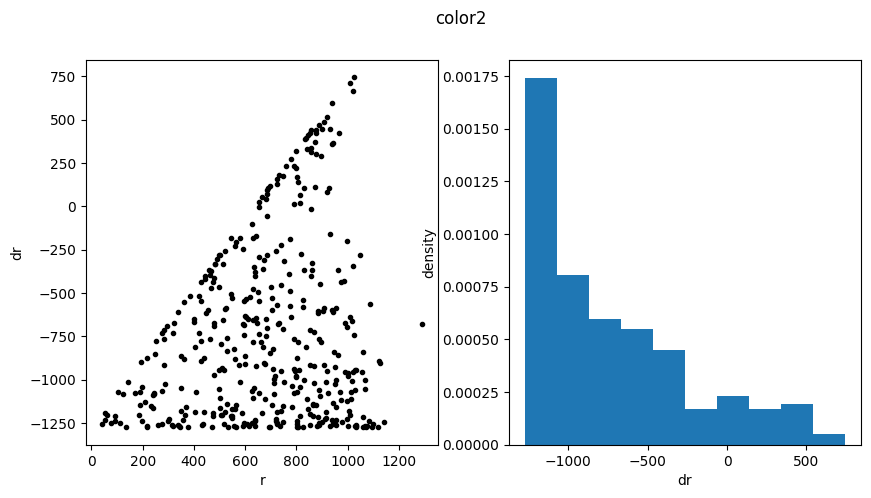

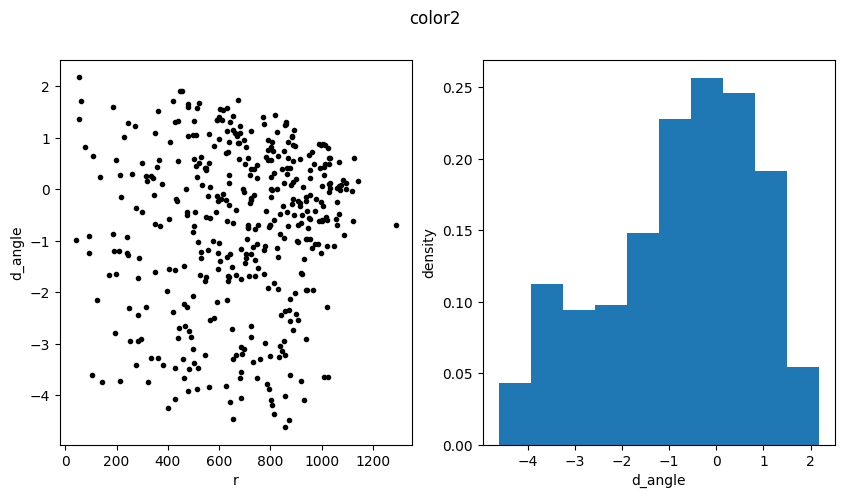

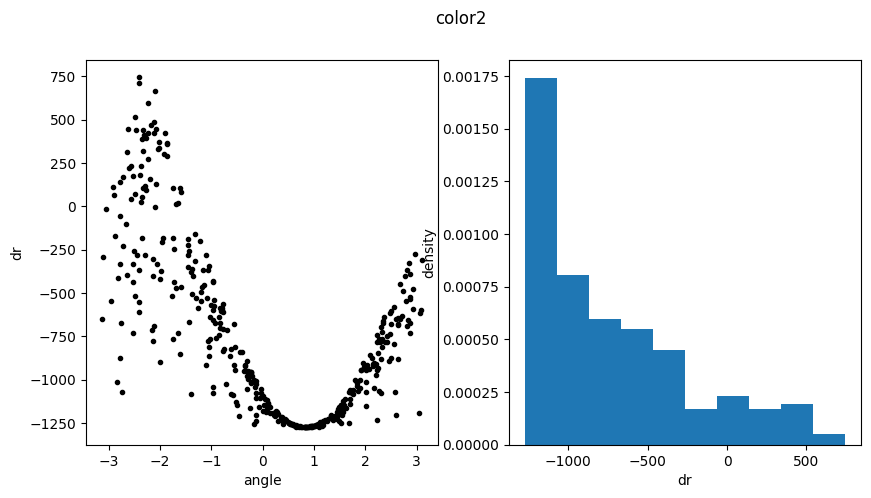

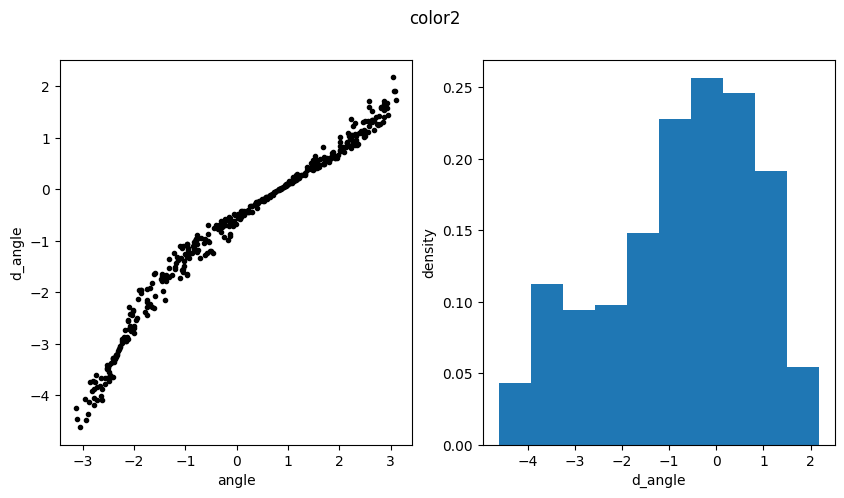

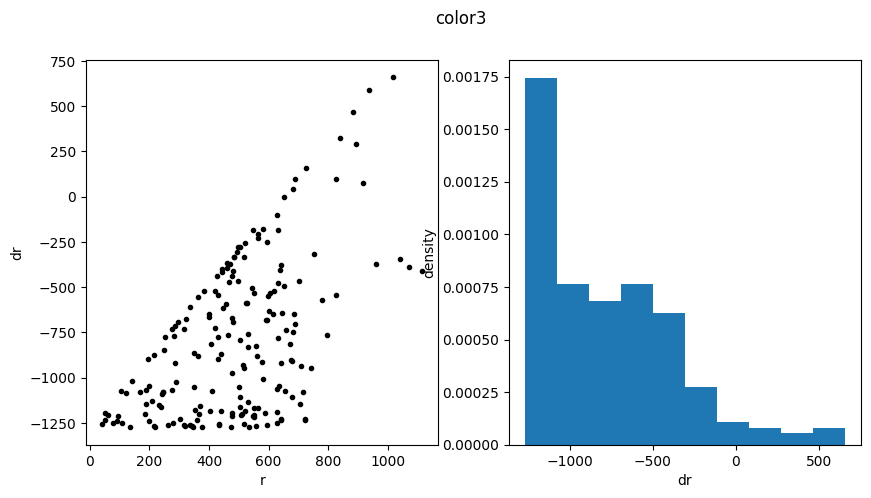

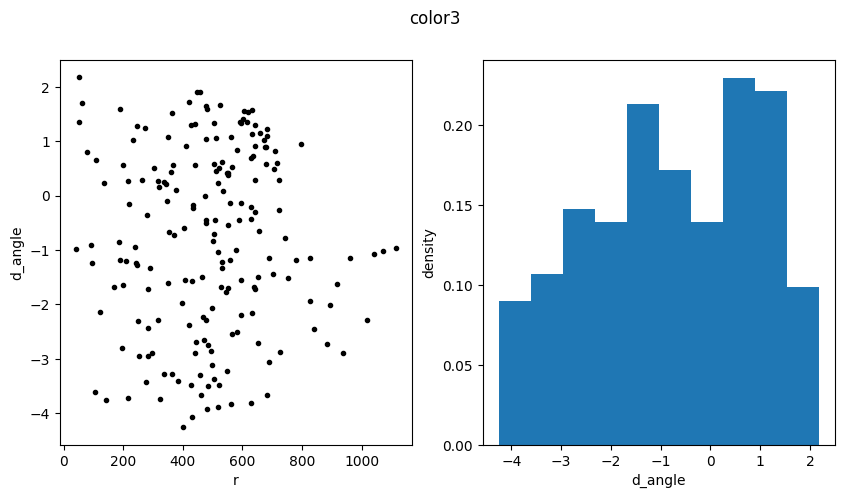

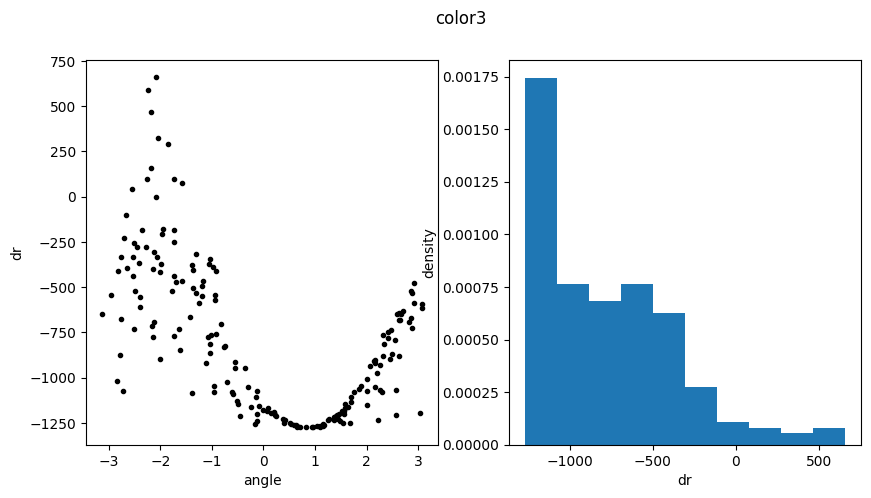

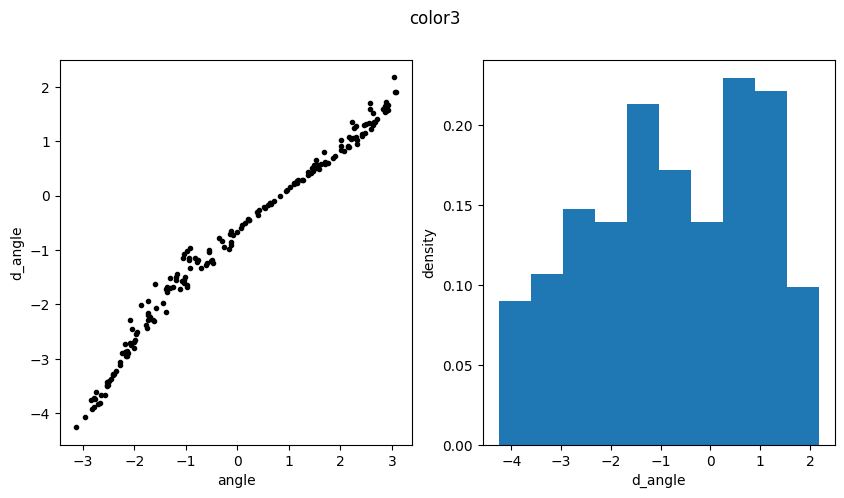

In [506]:
from itertools import product
for name in other_spots_name :
    sub_data = distance_df.loc[distance_df['channel'] == name]
    for i,di in product(['r','angle'], ['dr','d_angle']) :
        fig = plt.figure(figsize=(10,5))
        left,right = fig.subplots(1,2)
        left.plot(
            sub_data[i],
            sub_data[di],
            '.k'
        )
        left.set_xlabel('{0}'.format(i))
        left.set_ylabel('{0}'.format(di))

        right.hist(sub_data[di], density=True)
        right.set_xlabel(di)
        right.set_ylabel('density')
        plt.suptitle(name)
        fig.show()

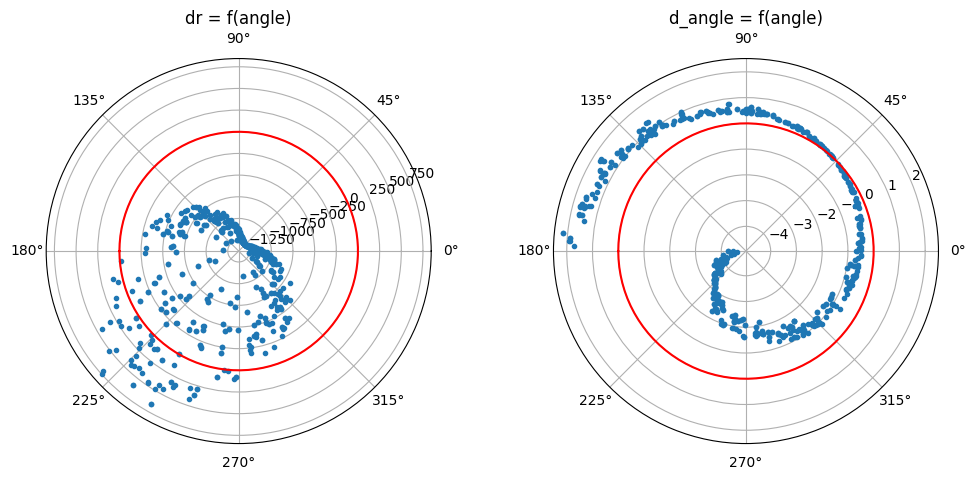

In [507]:
fig = plt.figure(figsize=(12,5))
left,right = fig.subplots(1,2, subplot_kw={'projection':'polar'})

left.plot(
    distance_df['angle'],
    distance_df['dr'],
    '.'
)
left.plot(
    np.linspace(-np.pi,np.pi,100),
    [0]*100,
    'r'
)
left.set_title('dr = f(angle)')

right.plot(
    distance_df['angle'],
    distance_df['d_angle'],
    '.'
)
right.plot(
    np.linspace(-np.pi,np.pi,100),
    [0]*100,
    'r'
)
right.set_title('d_angle = f(angle)')

plt.show()

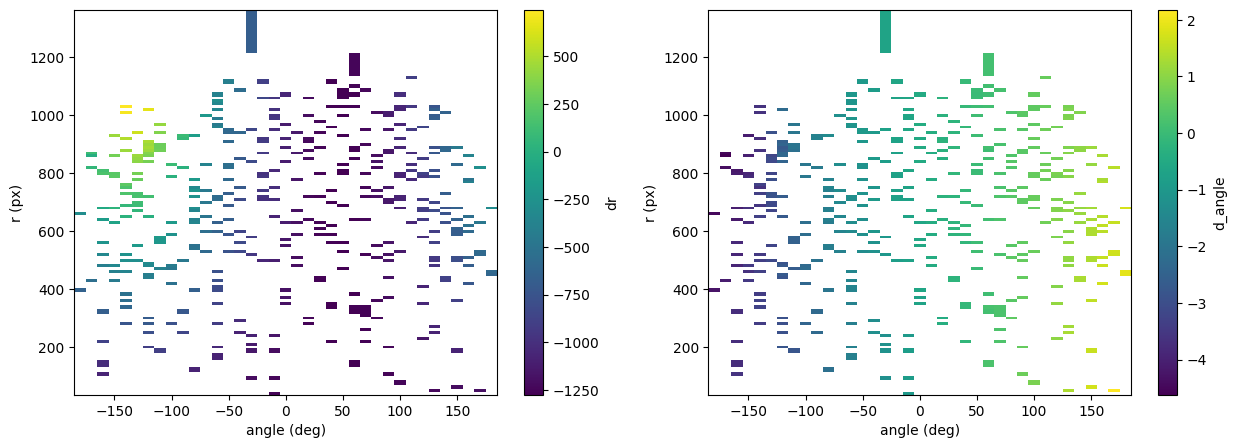

In [508]:
from matplotlib import colormaps
color_map = colormaps['viridis']
color_map.set_bad(color='white')

sub_data = distance_df.copy()
sub_data['r'] = sub_data['r'].round(-1)
sub_data['angle(deg)'] = sub_data['angle(deg)'].round(-1)

grid = pd.DataFrame(
    index= sub_data['r'].sort_values().unique(), 
    columns= pd.MultiIndex.from_tuples(product(sub_data['angle(deg)'].sort_values().unique(),['dr','d_angle'],)), 
    dtype=(float)
    )


sub_data = sub_data.groupby(['angle(deg)','r'])[['dr','d_angle']].mean()
for col in sub_data.index.get_level_values(0) :
    sub_data_selec = sub_data.loc[col]
    grid.loc[sub_data_selec.index,(col,'dr')] = sub_data_selec['dr']
    grid.loc[sub_data_selec.index,(col,'d_angle')] = sub_data_selec['d_angle']

grid = grid.dropna(axis=0, how='all')
grid = grid.dropna(axis=1, how='all')
grid = grid.swaplevel(axis=1,i=0,j=1).sort_index(axis=1)

fig = plt.figure(figsize=(15,5))
left,right = fig.subplots(1,2)

x = grid.columns.get_level_values(1).unique().to_numpy()
y = grid.index.to_numpy()

left_colormesh = left.pcolormesh(
    x,y,
    grid['dr'].to_numpy(), 
    cmap= color_map
    )

right_colormesh = right.pcolormesh(
    x,y,
    grid['d_angle'].to_numpy(), 
    cmap=color_map
    )

left.set_xlabel('angle (deg)')
left.set_ylabel('r (px)')
right.set_xlabel('angle (deg)')
right.set_ylabel('r (px)')


plt.colorbar(left_colormesh,label= 'dr')
plt.colorbar(right_colormesh,label = 'd_angle')

plt.show()


### Fixed angle

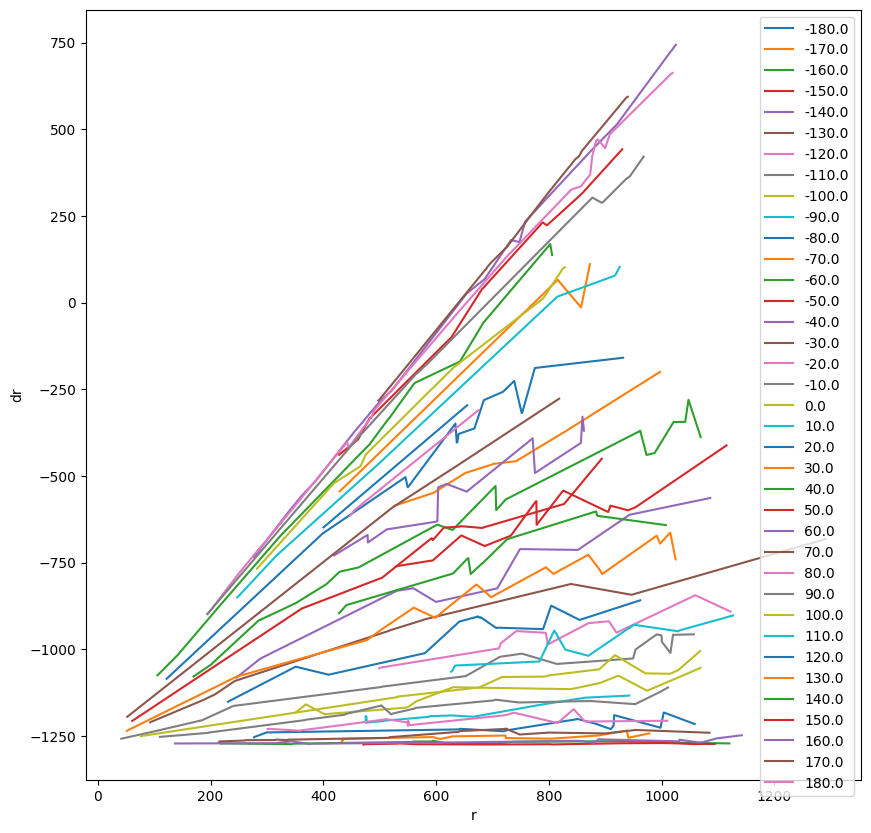

In [509]:
distance_df['angle_rounded(deg)'] = distance_df['angle(deg)'].round(-1)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for ang in distance_df['angle_rounded(deg)'].sort_values().unique() :
    sub_data = distance_df[distance_df['angle_rounded(deg)'] == ang]

    

    ax.plot(
        sub_data.sort_values('r')['r'],
        sub_data.sort_values('r')['dr'],
        '-',
        label= ang
    )

    ax.set_xlabel('r')
    ax.set_ylabel('dr')

plt.legend()
plt.show()


### Drift on cartesian axis as function of angle

               Z      Y      X  distance_to_reference_spot  matching_Z  \
angle(deg)                                                               
-180.0      22.0 -527.5  -10.5                  258.657625        23.0   
-170.0      22.0 -822.0 -131.5                  286.833135        23.0   
-160.0      22.0 -481.0 -172.0                  216.898594        23.0   
-150.0      22.0 -570.0 -374.0                  242.524226        23.0   
-140.0      22.0 -506.0 -421.5                  211.140677        23.0   
-130.0      22.0 -484.0 -591.0                  242.524226        23.0   
-120.0      22.0 -357.0 -630.0                  242.524226        23.0   
-110.0      22.0 -258.0 -826.0                  242.524226        23.0   
-100.0      22.0  -91.5 -526.5                  250.456864        23.0   
-90.0       21.5  -21.0 -654.5                  428.077976        23.0   
-80.0       23.0   99.5 -642.5                  295.033896        23.0   
-70.0       23.0  271.0 -646.0        

/tmp/ipykernel_56311/701346783.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data = mean_data.groupby('angle(deg)').median()
/tmp/ipykernel_56311/701346783.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_56311/701346783.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data = mean_data.groupby('angle(deg)').median()
/tmp/ipykernel_56311/701346783.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI bac

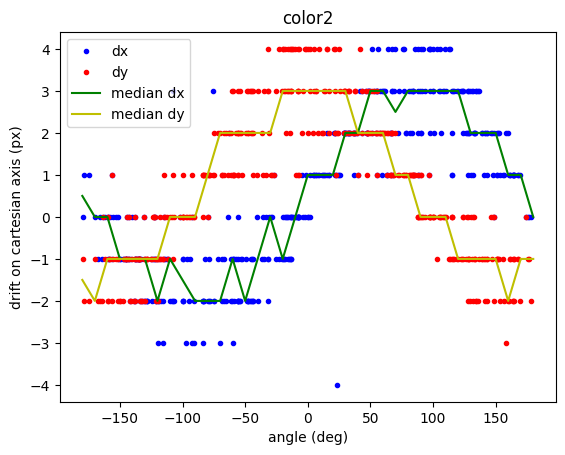

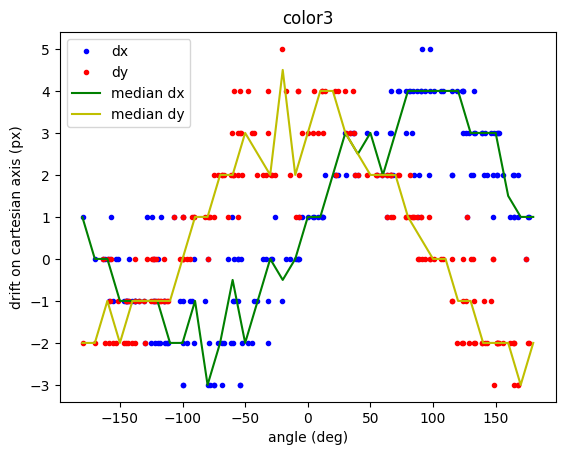

In [510]:
for name in other_spots_name :
    sub_data = distance_df.loc[distance_df['channel'] == name]

    mean_data = sub_data.copy()
    mean_data['angle(deg)'] = mean_data['angle(deg)'].round(-1)
    mean_data = mean_data.groupby('angle(deg)').median()
    print(mean_data)

    fig = plt.figure()
    ax = fig.gca()

    #all points
    ax.plot(
        sub_data.sort_values('angle')['angle(deg)'],
        sub_data.sort_values('angle')['dx'],
        '.b',
        label= 'dx'
    )
    ax.plot(
        sub_data.sort_values('angle')['angle(deg)'],
        sub_data.sort_values('angle')['dy'],
        '.r',
        label= 'dy'
    )

    #mean distributions
    ax.plot(
        mean_data.index,
        mean_data['dx'],
        'g',
        label= 'median dx'
    )
    ax.plot(
        mean_data.index,
        mean_data['dy'],
        'y',
        label= 'median dy'
    )

    ax.set_title(name)

    ax.set_xlabel('angle (deg)')
    ax.set_ylabel('drift on cartesian axis (px)')

    ax.legend()
    fig.show()

## Aberration dependency in Z

We try to investigate if Z is determinant for chromatic aberration in our optical system.

### Dr = f(angle) for z fixed
Lets plot dx for z fixed

/tmp/ipykernel_56311/4121330633.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


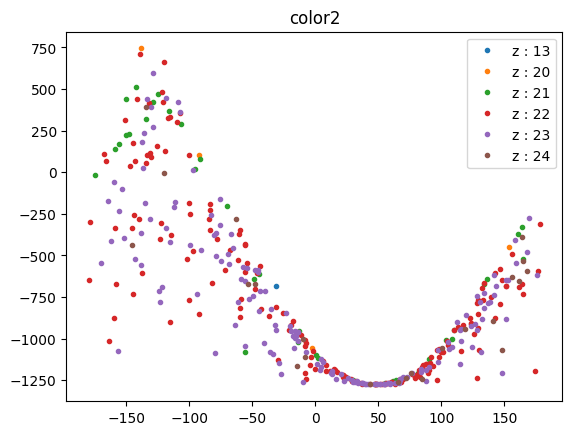

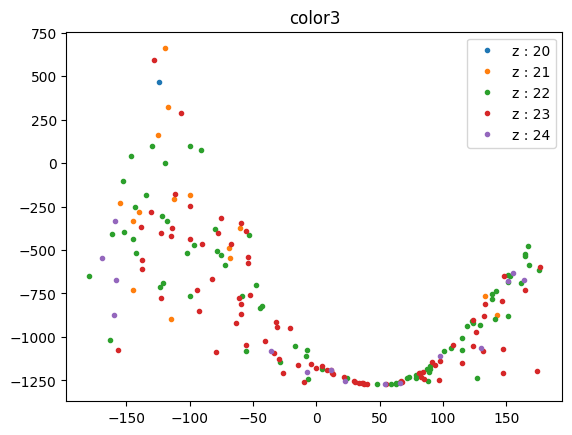

In [511]:
for name in other_spots_name :
    sub_data = distance_df.loc[distance_df['channel'] == name]

    fig = plt.figure()
    ax = fig.gca()

    for z in sub_data['Z'].unique() :
        #all points
        ax.plot(
            sub_data.query('Z == {0}'.format(z)).sort_values('angle')['angle(deg)'],
            sub_data.query('Z == {0}'.format(z)).sort_values('angle')['dr'],
            '.',
            label= 'z : {0}'.format(z),
        )

    ax.set_title(name)

    ax.legend()
    fig.show()

### Dr = f(z)

/tmp/ipykernel_56311/2685135779.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


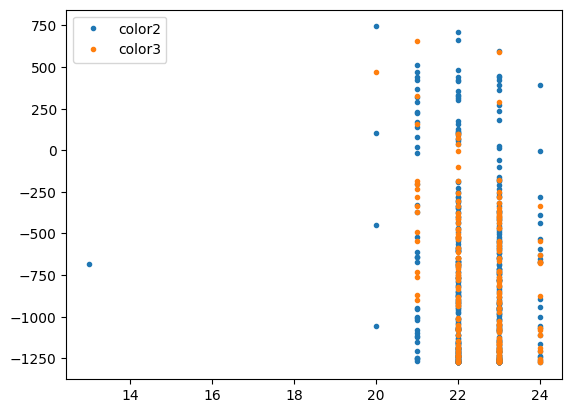

In [512]:
fig = plt.figure()
ax = fig.gca()
for name in other_spots_name :
    sub_data = distance_df.loc[distance_df['channel'] == name]

    #all points
    ax.plot(
        sub_data.sort_values('Z')['Z'],
        sub_data.sort_values('Z')['dr'],
        '.',
        label= name,
    )

    ax.legend()
    fig.show()

Conclusion : Z is not determinant in correction calculation, this could be caused by the plane to plane excitation of the optical system.

# Interpolation

In [513]:
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator

rng = np.random.default_rng(seed=1)

distance_df_color2 = distance_df.loc[distance_df.query('channel == "color2"').index]
distance_df_color3 = distance_df.loc[distance_df.query('channel == "color3"').index]

sample_color2 = distance_df_color2.sample(frac=0.8)
sample_color3 = distance_df_color3.sample(frac=0.8)

In [517]:
sample_color2_spots = np.array(list(zip(sample_color2.loc[:,['Z','r','angle']].to_numpy())), dtype=int).squeeze()

color2_interpolator = NearestNDInterpolator(
  sample_color2_spots,
  sample_color2['dx'].to_numpy(),
)

In [518]:
color2_spots_ = np.array(list(zip(distance_df_color2.loc[:,['Z','Y','X']].to_numpy())), dtype=int).squeeze()
distance_df_color2['inter_dx'] = color2_interpolator(color2_spots_)
distance_df_color2['inter_dx'] = distance_df_color2['inter_dx'].round()
distance_df_color2_res = distance_df_color2.drop(sample_color2.index)

distance_df_color2_res['error'] = distance_df_color2_res['dx'] - distance_df_color2_res['inter_dx']

<Axes: >

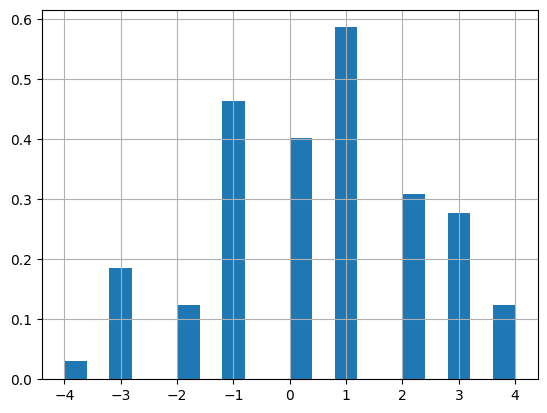

In [519]:
distance_df_color2_res['error'].astype(int).hist(density=True, bins= 20)